In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from PIL import Image
# to install pytorch, follow instructions on https://pytorch.org/get-started/locally/
# if CUDA is installed, this should allow GPU training
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
# -> pip install torchsummary
from torchsummary import summary

In [2]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np

# Path to expanded dataset
dataset_dir = r"C:\Users\antoi\Documents\BirdSpeciesRecognitionProject\DATA"

# Step 1: Load images and labels from the dataset directory
def load_images_from_directory(directory, target_size=(256, 256)):
    images = []
    labels = []
    # Get sorted list of class names (subdirectories), ensures consistent label order
    class_names = sorted(os.listdir(directory))
    # Map class names to integer indices
    class_to_index = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue  # Skip if not a directory

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                # Open image, convert to RGB, resize to target size
                img = Image.open(img_path).convert("RGB")
                img = img.resize(target_size)
                images.append(np.array(img))  # Convert image to numpy array
                labels.append(class_to_index[class_name])  # Store label as integer
            except Exception as e:
                print(f"Skipping {img_path}: {e}")  # Skip unreadable images

    return np.array(images), np.array(labels), class_to_index

# Load all images and labels, and get the label map
images, labels, label_map = load_images_from_directory(dataset_dir)

# Step 2: Split into training and validation sets (80% train, 20% validation)
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

# Transpose images to match PyTorch's expected input shape: (N, C, H, W)
train_images = train_images.transpose(0, 3, 1, 2)
val_images = val_images.transpose(0, 3, 1, 2)

# Print dataset summary
print("Dataset split complete:")
print(f"Train set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")
print("Label map:", label_map)

Dataset split complete:
Train set: 2392 images
Validation set: 599 images
Label map: {'accenteur_mouchet': 0, 'autre': 1, 'chardonneret': 2, 'choucas': 3, 'colombe_a_collier': 4, 'corbeau_charognard': 5, 'etourneau': 6, 'grande_mesange': 7, 'grive_musicienne': 8, 'merle': 9, 'mesange_bleue': 10, 'mesange_charbonniere': 11, 'moineau': 12, 'mésange_a_longue_queue': 13, 'pie': 14, 'pigeon_biset': 15, 'pigeon_des_bois': 16, 'pinson': 17, 'roitelet': 18, 'rouge_gorge': 19, 'verdier': 20}


In [3]:
from torch.utils.data import ConcatDataset

# How many augmented versions per image you want:
copies_per_image = 10  # You can change this to any number you like

# Define a set of data augmentation transformations
transform = transforms.Compose([
    transforms.RandomRotation(20, fill=(255, 255, 255)),  # Random rotation with white border
    transforms.RandomAffine(20, translate=(0.2, 0.2), fill=(255, 255, 255)),  # Random shifts with white border
    transforms.RandomHorizontalFlip(),  # Random horizontal flips
    transforms.ColorJitter(brightness=(0.8, 1.2)),  # Random brightness adjustment
    transforms.ToTensor()  # Convert image to tensor
])



# Apply the transformations to the training dataset
class AugmentedDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        # If it's a PyTorch tensor, convert to NumPy
        if torch.is_tensor(image):
            image = image.numpy()

        # If shape is (C, H, W), convert to (H, W, C)
        if image.ndim == 3 and image.shape[0] == 3:
            image = np.transpose(image, (1, 2, 0))  # Convert from CHW to HWC

        # Fix: Handle grayscale or RGB image formats
        if image.ndim == 3 and image.shape[0] == 1:
            image = np.squeeze(image, axis=0)  # (1, H, W) -> (H, W)
        elif image.ndim == 3 and image.shape[2] == 1:
            image = np.squeeze(image, axis=2)  # (H, W, 1) -> (H, W)

        if image.ndim == 2:  # Grayscale
            pil_image = Image.fromarray(image.astype('uint8'), mode='L').convert('RGB')
        elif image.ndim == 3 and image.shape[2] == 3:  # RGB
            pil_image = Image.fromarray(image.astype('uint8'), mode='RGB')
        else:
            raise ValueError(f"Unsupported image shape: {image.shape}")

        if self.transform:
            image_tensor = self.transform(pil_image)
        else:
            image_tensor = transforms.ToTensor()(pil_image)

        label = self.labels[idx]
        return image_tensor, label


# Create the augmented dataset
#augmented_dataset = AugmentedDataset(train_images, train_labels, transform=transform)

# Create N versions of the same dataset (each with random transforms)
augmented_dataset_repeated = ConcatDataset([AugmentedDataset(train_images, train_labels, transform=transform) 
                                             for _ in range(copies_per_image)])

# Create a DataLoader to efficiently load batches of augmented training data during model training
augmented_loader = DataLoader(augmented_dataset_repeated, batch_size=32, shuffle=True)

In [4]:
from torch.utils.data import TensorDataset

# Convert validation images to torch tensor, normalize to [0, 1] by dividing by 255
validation_images_tensor = torch.from_numpy(val_images).float().div(255)

# Convert validation labels to torch tensor of type long (for classification)
validation_labels_tensor = torch.from_numpy(val_labels).long()

# Create a TensorDataset for validation data
validation_dataset = TensorDataset(validation_images_tensor, validation_labels_tensor)

# Create a DataLoader for the validation dataset (no shuffling)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

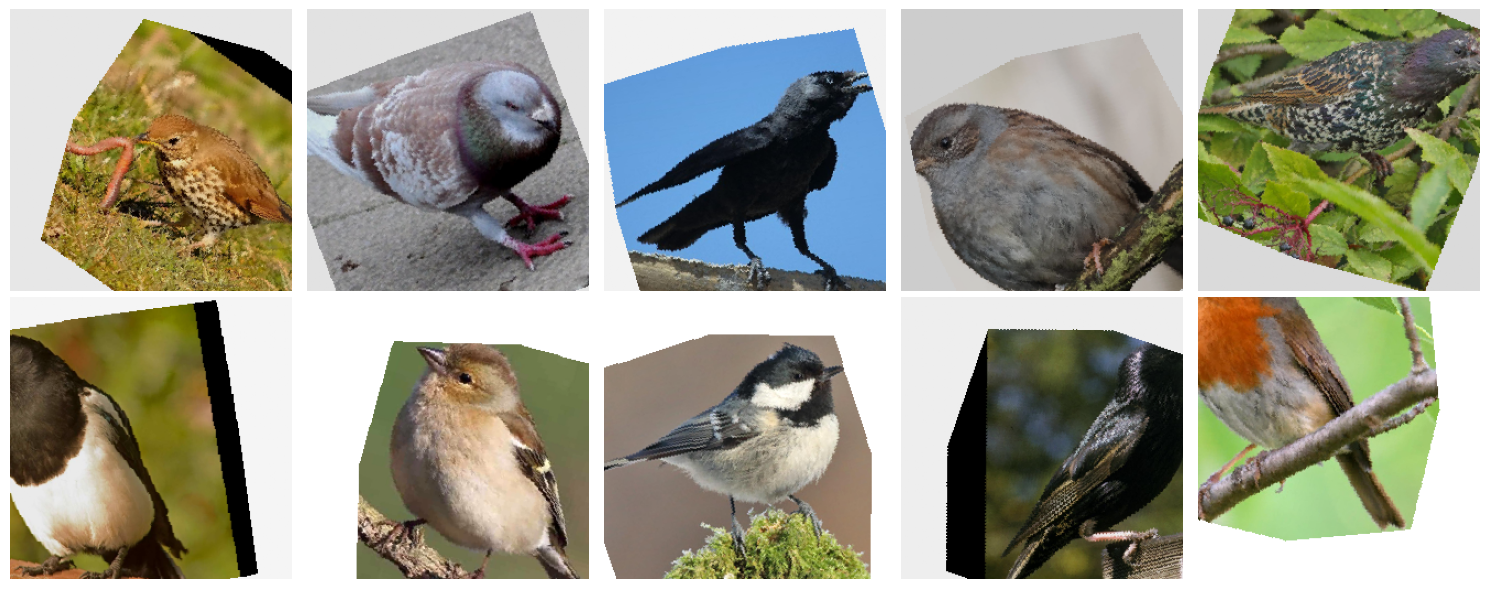

In [5]:
# Generate a batch of augmented images
augmented_images, _ = next(iter(augmented_loader))

# Convert the images to numpy format for visualization
augmented_images = augmented_images.permute(0, 2, 3, 1).numpy()

# Create a grid to display the images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Display each image in the grid
for img, ax in zip(augmented_images, axes):
    ax.imshow(img)
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

In [6]:
class BirdSpeciesCNNModel(nn.Module):
    def __init__(self):
        super(BirdSpeciesCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(p=0.2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(p=0.2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=0)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(p=0.2)

        # New layer
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=0)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout5 = nn.Dropout(p=0.2)

        # Dynamically calculate the flattened size
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 256, 256)  # Adjust input size if needed
            x = self.pool1(F.relu(self.conv1(dummy_input)))
            x = self.pool2(F.relu(self.conv2(x)))
            x = self.pool3(F.relu(self.conv3(x)))
            x = self.pool4(F.relu(self.conv4(x)))
            x = self.pool5(F.relu(self.conv5(x)))
            self.flatten_size = x.numel()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.flatten_size, 1024)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(1024, 21)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.dropout4(x)
        x = self.pool5(F.relu(self.conv5(x)))  # Include the new layer
        x = self.dropout5(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

# Example of model instantiation
model = BirdSpeciesCNNModel()
print(model)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BirdSpeciesCNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.2, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout4): Dropout(p=0.2, inplace=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout5): Dropout(p=0.2, inplace=False)
  (flatten): Flatten

BirdSpeciesCNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.2, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout4): Dropout(p=0.2, inplace=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout5): Dropout(p=0.2, inplace=False)
  (flatten): Flatten

In [7]:
from torchviz import make_dot

# IMPORTANT: You must also install the Graphviz system package and add its bin folder to your PATH.
# Download from: https://graphviz.gitlab.io/download/
# After installation, add the Graphviz 'bin' directory (e.g., C:\Program Files\Graphviz\bin) to your system PATH.

# Create a dummy input tensor with the same shape as the model expects
dummy_input = torch.randn(1, 3, 256, 256).to(device)

# Get the model output
model.eval()
output = model(dummy_input)

# Visualize the model graph
dot = make_dot(output, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('cnn_model_graph.png', view=True)

'cnn_model_graph.png.png'

In [8]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256))  # Adjust input size if needed

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)  # Adam optimizer

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 254, 254]             896
         MaxPool2d-2         [-1, 32, 127, 127]               0
           Dropout-3         [-1, 32, 127, 127]               0
            Conv2d-4         [-1, 64, 125, 125]          18,496
         MaxPool2d-5           [-1, 64, 62, 62]               0
           Dropout-6           [-1, 64, 62, 62]               0
            Conv2d-7          [-1, 128, 60, 60]          73,856
         MaxPool2d-8          [-1, 128, 30, 30]               0
           Dropout-9          [-1, 128, 30, 30]               0
           Conv2d-10          [-1, 256, 28, 28]         295,168
        MaxPool2d-11          [-1, 256, 14, 14]               0
          Dropout-12          [-1, 256, 14, 14]               0
           Conv2d-13          [-1, 512, 12, 12]       1,180,160
        MaxPool2d-14            [-1, 51

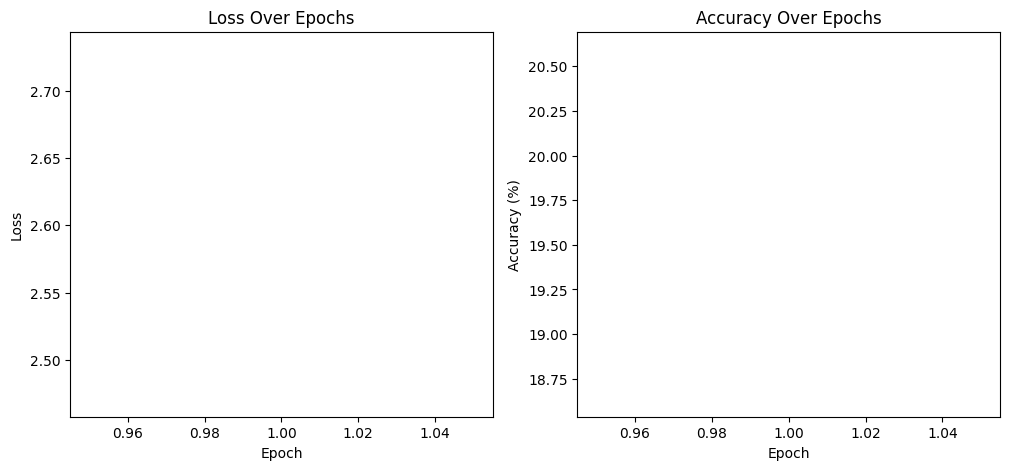

Epoch 1/20, Loss: 2.6008, Accuracy: 19.62%, Images processed: 23920


<Figure size 640x480 with 0 Axes>

Epoch 2/20, Loss: 1.5172, Accuracy: 52.11%, Images processed: 23920


<Figure size 640x480 with 0 Axes>

Epoch 3/20, Loss: 0.9827, Accuracy: 68.15%, Images processed: 23920


<Figure size 640x480 with 0 Axes>

Epoch 4/20, Loss: 0.6928, Accuracy: 77.70%, Images processed: 23920


<Figure size 640x480 with 0 Axes>

Epoch 5/20, Loss: 0.5003, Accuracy: 83.35%, Images processed: 23920


<Figure size 640x480 with 0 Axes>

Epoch 6/20, Loss: 0.3776, Accuracy: 87.53%, Images processed: 23920


<Figure size 640x480 with 0 Axes>

Epoch 7/20, Loss: 0.2955, Accuracy: 90.43%, Images processed: 23920


<Figure size 640x480 with 0 Axes>

Epoch 8/20, Loss: 0.2518, Accuracy: 91.75%, Images processed: 23920


<Figure size 640x480 with 0 Axes>

Epoch 9/20, Loss: 0.2098, Accuracy: 93.18%, Images processed: 23920


<Figure size 640x480 with 0 Axes>

Epoch 10/20, Loss: 0.1846, Accuracy: 93.80%, Images processed: 23920


<Figure size 640x480 with 0 Axes>

Epoch 11/20, Loss: 0.1572, Accuracy: 95.08%, Images processed: 23920


<Figure size 640x480 with 0 Axes>

Epoch 12/20, Loss: 0.1515, Accuracy: 95.24%, Images processed: 23920


<Figure size 640x480 with 0 Axes>

Epoch 13/20, Loss: 0.1351, Accuracy: 95.69%, Images processed: 23920


<Figure size 640x480 with 0 Axes>

Epoch 14/20, Loss: 0.1136, Accuracy: 96.35%, Images processed: 23920


<Figure size 640x480 with 0 Axes>

Epoch 15/20, Loss: 0.1182, Accuracy: 96.19%, Images processed: 23920


<Figure size 640x480 with 0 Axes>

Epoch 16/20, Loss: 0.1083, Accuracy: 96.54%, Images processed: 23920


<Figure size 640x480 with 0 Axes>

Epoch 17/20, Loss: 0.0978, Accuracy: 96.90%, Images processed: 23920


<Figure size 640x480 with 0 Axes>

Epoch 18/20, Loss: 0.0868, Accuracy: 97.24%, Images processed: 23920


<Figure size 640x480 with 0 Axes>

Epoch 19/20, Loss: 0.0864, Accuracy: 97.27%, Images processed: 23920


<Figure size 640x480 with 0 Axes>

Epoch 20/20, Loss: 0.0947, Accuracy: 97.06%, Images processed: 23920
CPU times: total: 2h 59min 7s
Wall time: 22min 38s


In [9]:
%%time

batch_size = 32  # Adjusted batch size for augmented dataset
epochs = 20  # Define the number of epochs for training

# Recreate the dataloader with the new batch size
# Use augmented_dataset_repeated for augmentation as in previous cells
augmented_loader = DataLoader(augmented_dataset_repeated, batch_size=batch_size, shuffle=True)

# Initialize lists to store loss and accuracy history
loss_history = []
accuracy_history = []

# Set up real-time plotting
plt.ion()  # Turn on interactive mode
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("Loss Over Epochs")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].set_title("Accuracy Over Epochs")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy (%)")

loss_line, = ax[0].plot([], [], label="Loss", color="blue")
acc_line, = ax[1].plot([], [], label="Accuracy", color="green")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in augmented_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(augmented_loader)
    epoch_accuracy = 100 * correct / total

    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_accuracy)

    # Update the plots in real time
    loss_line.set_data(range(1, epoch + 2), loss_history)
    acc_line.set_data(range(1, epoch + 2), accuracy_history)
    ax[0].relim()
    ax[0].autoscale_view()
    ax[1].relim()
    ax[1].autoscale_view()
    plt.draw()
    plt.pause(0.1)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Images processed: {total}")

plt.ioff()
plt.show()

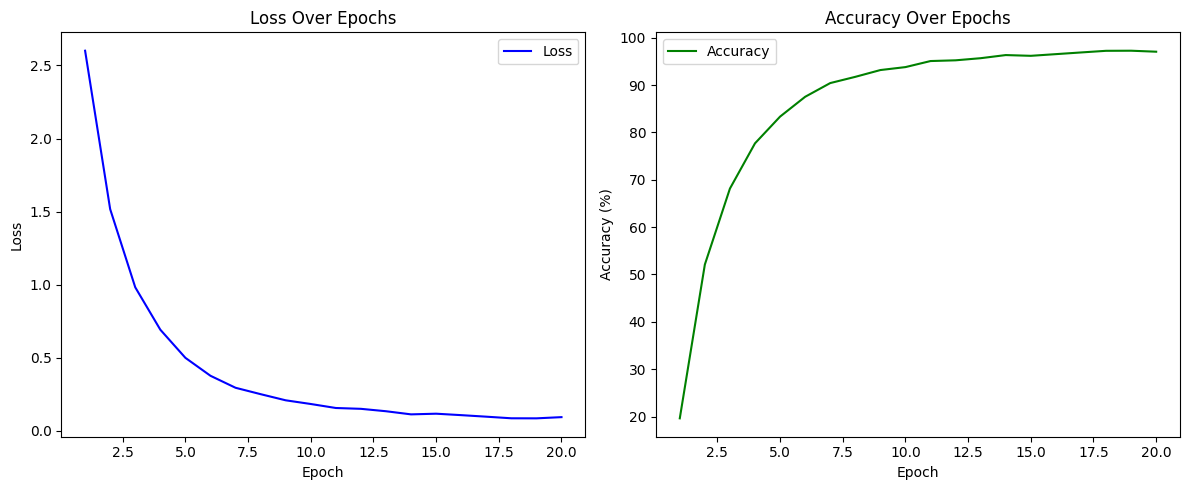

In [10]:
# Plot and save accuracy and loss graphs over epochs

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(range(1, len(loss_history) + 1), loss_history, color="blue", label="Loss")
ax[0].set_title("Loss Over Epochs")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(range(1, len(accuracy_history) + 1), accuracy_history, color="green", label="Accuracy")
ax[1].set_title("Accuracy Over Epochs")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy (%)")
ax[1].legend()

plt.tight_layout()
plt.savefig("accuracy_loss_over_epochs.png")
plt.show()

In [11]:
# Evaluation
model.eval()

correct = 0
total = 0

with torch.no_grad():  # Disable gradients for evaluation
    for test_X, test_y in validation_dataloader:
        # Move data to GPU
        test_X, test_y = test_X.to(device), test_y.to(device)

        # Forward pass
        test_outputs = model(test_X)
        
        # Get predictions
        _, predicted = torch.max(test_outputs, 1)  # Get the class with highest probability
        
        # Update total and correct predictions
        correct += (predicted == test_y).sum().item()
        total += test_y.size(0)

# Compute final accuracy across all batches
accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 78.96%


In [12]:
# Load and preprocess the image
def preprocess_image(image_path, target_size=(256, 256)):
    image = Image.open(image_path).convert("RGB")
    image = image.resize(target_size)
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

# Path to the test image
test_image_path = r"C:\Users\antoi\Documents\BirdSpeciesRecognitionProject\TestPics\téléchargement (3).jpg"

# Preprocess the image
test_image_tensor = preprocess_image(test_image_path).to(device)

# Set the model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    output = model(test_image_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

# Map the predicted class index to the class name
predicted_label = list(label_map.keys())[list(label_map.values()).index(predicted_class)]
print(f"Predicted class: {predicted_label}")

Predicted class: pinson


In [13]:
# Save the trained model's state_dict
model_save_path = "bird_species_cnn_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to bird_species_cnn_model.pth
